In [1]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
#### Preprocecing ###

In [3]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [4]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [5]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]
confirmed = confirmed.cummax()

In [6]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]
recovered = recovered.cummax()


In [7]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]
death = death.cummax()

In [8]:
### Data Preparation ###

In [16]:
country = 'Japan'
C0 = confirmed[country].values
R0 = (recovered)[country].values
D0 = death[country].values
P = 12000_0000
iter=200000
repeat = 1000
epoch = pd.to_datetime('2020-01-22')

In [17]:
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [18]:
### Model ###

In [13]:
sm = pystan.StanModel(file="turzin-start-q0.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_493f466295c2cc4d22fb55bd65c2ffb9 NOW.


In [19]:
# Train the model and generate samples
fit_start_q0 = sm.sampling(data=data, iter=iter, init=0)

In [20]:
fit_start_q0

Inference for Stan model: anon_model_493f466295c2cc4d22fb55bd65c2ffb9.
4 chains, each with iter=200000; warmup=100000; thin=1; 
post-warmup draws per chain=100000, total post-warmup draws=400000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   8.56  3.3e-3   1.65   5.81   7.39   8.38   9.53  12.28 254375    1.0
b0         0.11  6.5e-6 3.5e-3    0.1    0.1   0.11   0.11   0.11 298707    1.0
b1         0.14  3.6e-6 2.2e-3   0.14   0.14   0.14   0.14   0.14 374797    1.0
theta_b    1.24  1.0e-3   0.61   0.45    0.8   1.11   1.54   2.79 361766    1.0
b_date    58.23  2.3e-3   1.32  55.38  57.48  58.29  59.06  60.68 316862    1.0
q0         0.83  2.1e-4    0.1    0.6   0.77   0.84   0.91   0.97 223866    1.0
q1         0.25  7.8e-5   0.04   0.17   0.23   0.25   0.28   0.32 220633    1.0
theta_q    4.19  1.6e-3   1.02   2.44   3.48   4.11   4.81   6.44 409757    1.0
q_date    54.19  2.2e-4   0.13  53.92  54.11  54.19  54.28  54.44 361262    1.0
a  

In [23]:
def waic(fit):
    log_lik = fit['log_lik']
    lppd = np.log(np.exp(log_lik).mean(axis=0)).sum()
    p_waic = np.var(log_lik, axis=0).sum()
    waic = -2*lppd + 2*p_waic
    return waic

In [24]:
waic(fit_start_q0)

ValueError: No parameter log_lik

In [15]:
### Visualization functions ###

In [16]:
def sigmoid(x, theta, t0):
    return 1/(1 + np.exp(-theta*(x-t0)))

In [17]:
def simulate(init_inf, b0, b1, theta_b, b_date, q0, q1, theta_q, q_date,
             a, d, horizon):
    S = init_inf;
    R = 0;
    D = 0;
    S_list = [S]
    R_list = [R]
    D_list = [D]
    b_list = [b0]
    q_list = [0]
    S0 = [0]
    R0 = [0]
    D0 = [D]
    for t in range(horizon):
        b = b0 + (b1-b0) * sigmoid(t, theta_b, b_date)
        I = (S - R - D) * b * (1 - S/P)
        q = q0 + (q1 - q0) * sigmoid(t, theta_q, q_date)
        NR = a * (S - R - D)
        ND = d * (S - R - D)
        D = D + ND
        S = S + I
        R = R + NR
        S_list.append(S)
        R_list.append(R)
        D_list.append(D)
        b_list.append(b)
        q_list.append(q)
        S0.append(S0[-1]+q*I)
        R0.append(R0[-1]+a * (S0[-1] - R0[-1] - D0[-1]))
    data = pd.DataFrame({'S':np.array(S_list),
                        'R':np.array(R_list),
                        'D':np.array(D_list),
                        'b':np.array(b_list),
                        'q':np.array(q_list),
                        'S0':np.array(S0),
                        'R0':np.array(R0)},
                        index=pd.date_range(start=epoch, periods=horizon+1, freq='D'))
    return data

In [18]:
def monte_carlo(fit, horizon):
    S = pd.DataFrame()
    R = pd.DataFrame()
    D = pd.DataFrame()
    b = pd.DataFrame()
    q = pd.DataFrame()
    S0 = pd.DataFrame()
    R0 = pd.DataFrame()
    I0 = pd.DataFrame()
    n = fit['init_inf'].shape[0]
    for k in range(repeat):
        i = np.random.randint(n)
        df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q0=fit['q0'][i],
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      horizon=horizon)
        S = pd.concat([S, df['S']], axis=1)
        R = pd.concat([R, df['R']], axis=1)
        D = pd.concat([D, df['D']], axis=1)
        b = pd.concat([b, df['b']], axis=1)
        q = pd.concat([q, df['q']], axis=1)
        S0 = pd.concat([S0, df['S0']], axis=1)
        R0 = pd.concat([R0, df['R0']], axis=1)
        I0 = pd.concat([I0, df['S0'] - df['R0']], axis=1)
    return S, R, D, b, q, S0, R0, I0
    

In [19]:
def extract_series(fit, name):
    value_list = []
    for d in range(S0.shape[0]):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=confirmed.index)

In [20]:
def draw(simulated, real=None, upto=pd.to_datetime('today')):
    graph=pd.DataFrame(index=pd.date_range(start=epoch, end=upto))
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [21]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit, 120)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


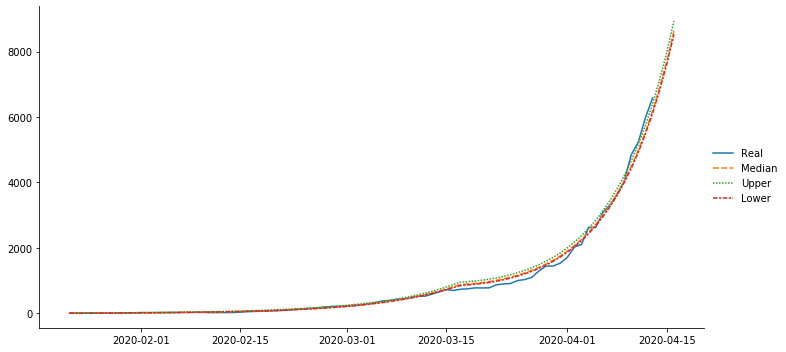

In [22]:
draw(I0, real=(confirmed-recovered)[country])

In [23]:
S.median(axis=1)[pd.to_datetime('2020-04-15')]

34234.4818859266

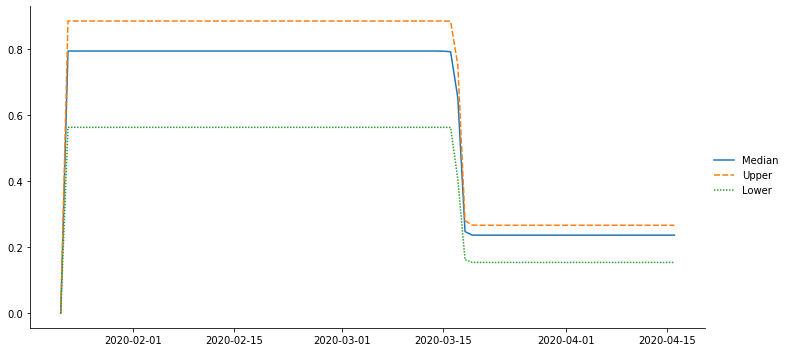

In [24]:
draw(q)

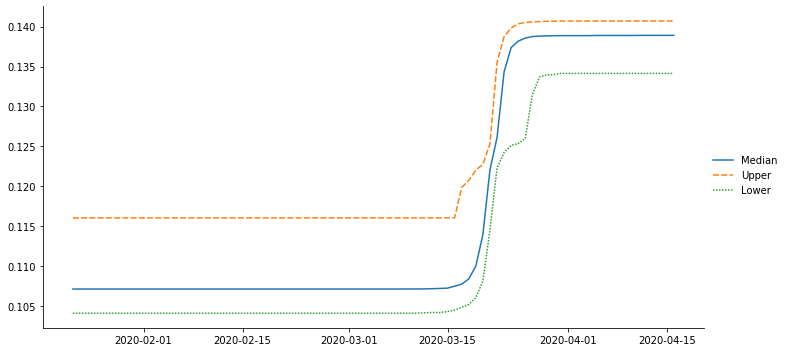

In [25]:
draw(b)

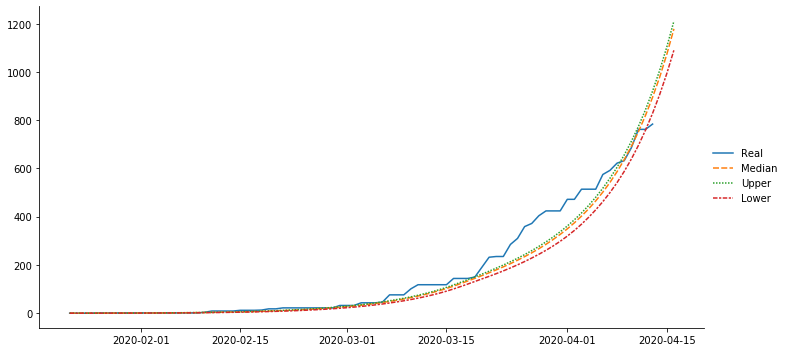

In [26]:
draw(R0, real=recovered[country])

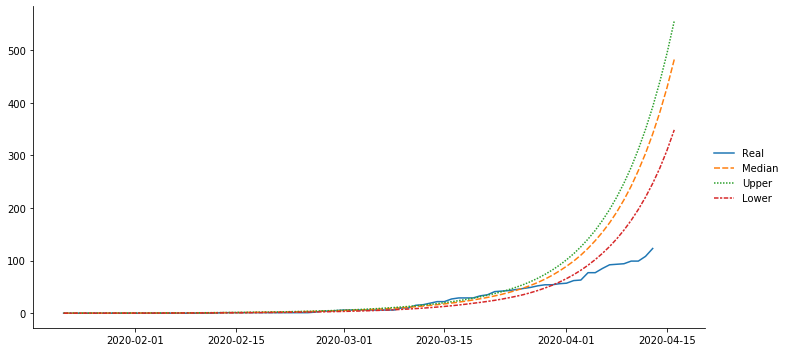

In [27]:
draw(D, real=death[country])

In [28]:
cumulative = pd.DataFrame(S.values, columns=range(len(S.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

In [29]:
predicted_recovered = pd.DataFrame(R.values, columns=range(len(R.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

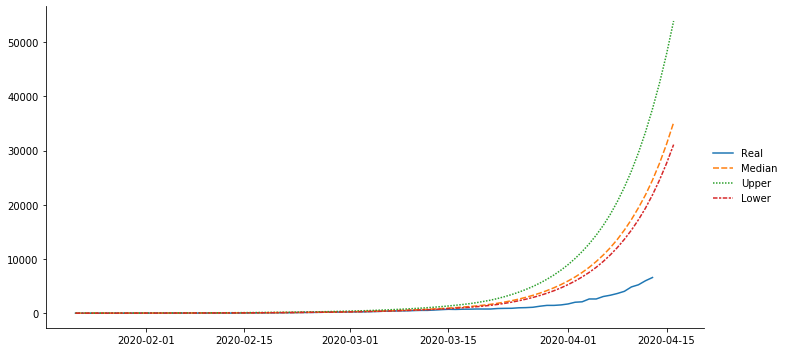

In [30]:
draw(cumulative - predicted_recovered, real=(confirmed-recovered)[country])

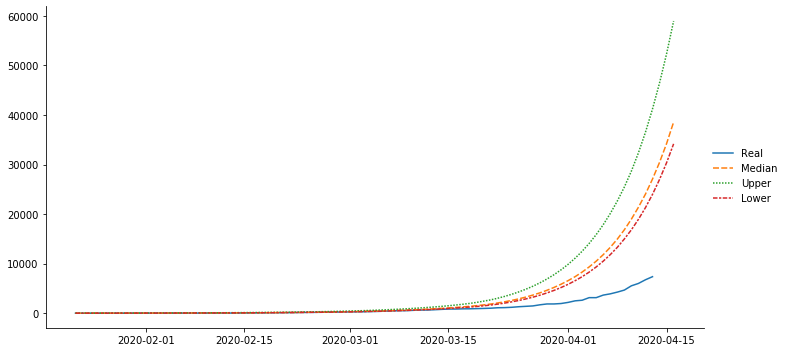

In [31]:
draw(cumulative, real=confirmed[country])

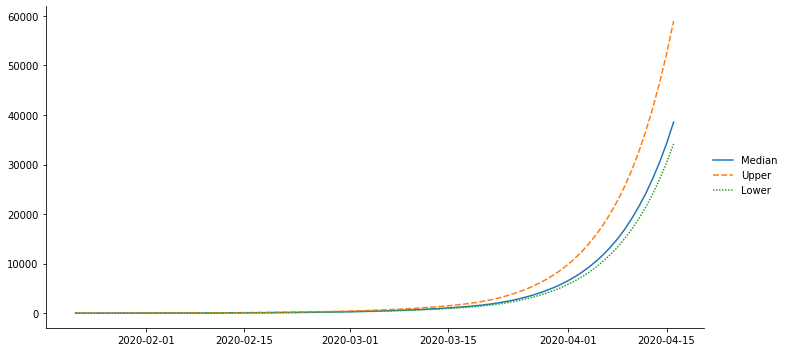

In [32]:
draw(S)

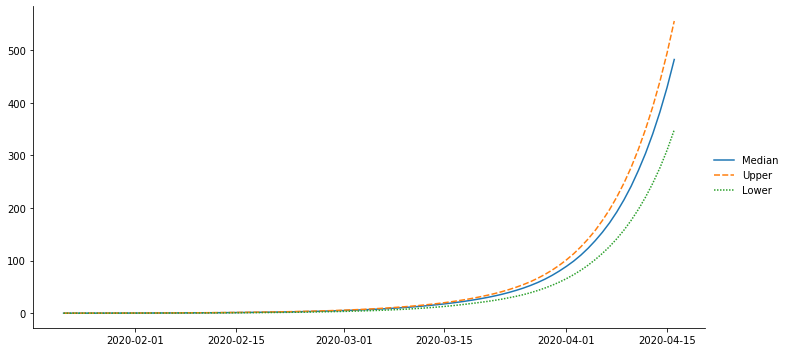

In [33]:
draw(D)

In [34]:
country = 'Korea, South'
C0 = confirmed[country].values
R0 = (recovered)[country].values
D0 = death[country].values
P = 5170_0000
iter=100000
repeat = 1000
epoch = pd.to_datetime('2020-01-22')
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [35]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=iter, init=0)

In [36]:
fit

Inference for Stan model: anon_model_baf43d40477fa115ab9879d2b12e82c2.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   4.06    2.64   4.29   0.02   0.07   3.57   7.51  12.83      3   1.96
b0         0.46    0.04   0.05   0.39   0.41   0.47   0.51   0.54      2   4.74
b1      10.0e-3  7.1e-3   0.01 6.1e-6 9.7e-6   0.01   0.02   0.02      2   4.45
theta_b     0.4    0.07   0.11   0.27    0.3   0.38    0.5   0.54      2   4.74
b_date    42.22    0.04   0.86  40.89  41.85  42.23  42.49  43.78    502   1.02
q0         0.15    0.11   0.22 1.8e-4 2.4e-4 4.7e-4   0.26   0.73      4   1.44
q1         0.43    0.18    0.3   0.01   0.15    0.4   0.72   0.93      3   1.82
theta_q    3.18    2.02   3.01   0.34   0.37    1.0   5.76   8.85      2   2.93
q_date    56.08   11.68  16.52  39.37  39.58  53.54   72.6  73.88      2  30.11
a    

In [37]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit, 120)

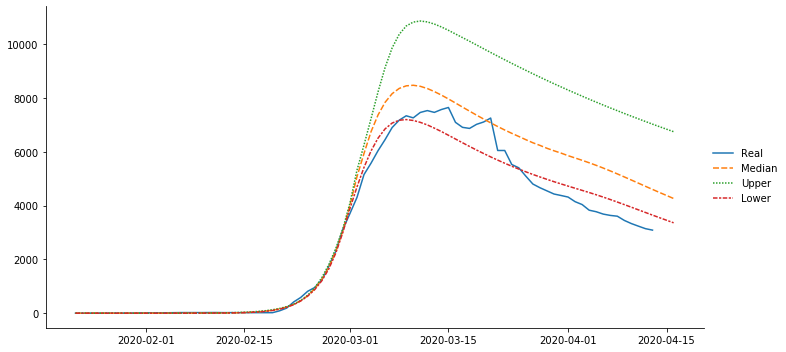

In [38]:
draw(I0, real=(confirmed-recovered)[country])

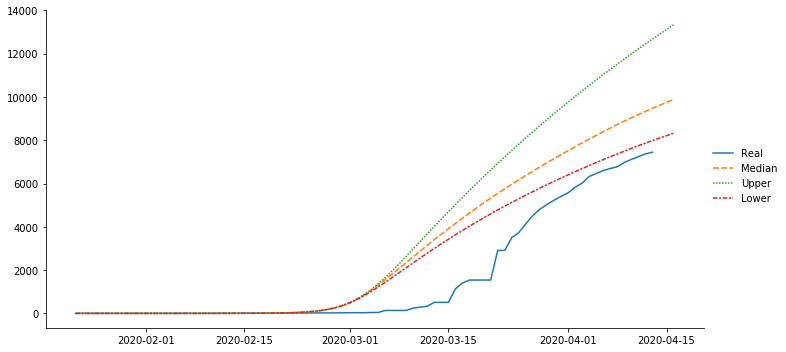

In [39]:
draw(R0, real=recovered[country])

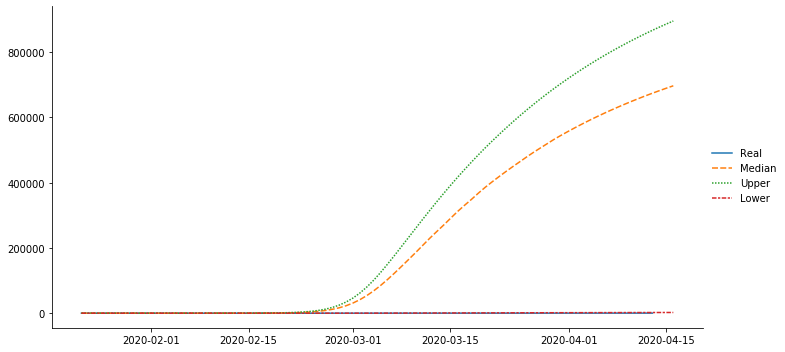

In [40]:
draw(D, real=death[country])

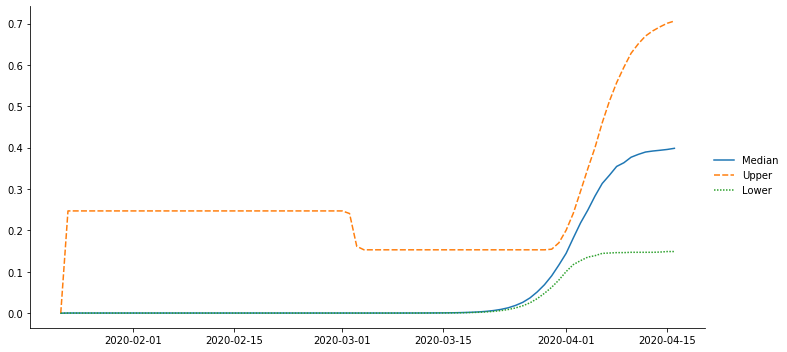

In [41]:
draw(q)

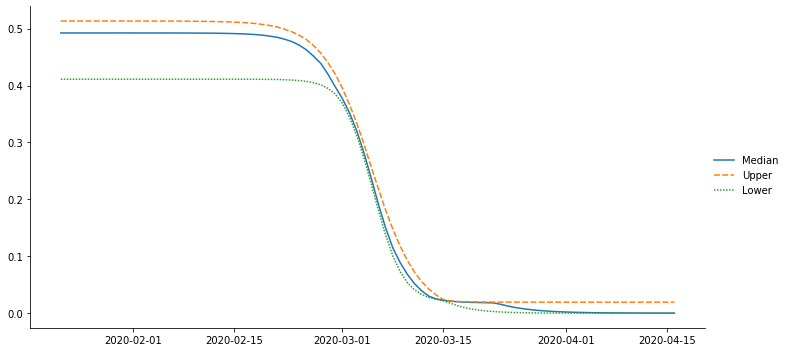

In [42]:
draw(b)

In [ ]:
country = 'Italy'
epoch = pd.to_datetime('2020-02-01')
C0 = confirmed.loc[epoch:, country].values
R0 = (recovered).loc[epoch:, country].values
D0 = death.loc[epoch:, country].values
P = 6000_0000
iter=100000
repeat = 1000
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
fit = sm.sampling(data=data, iter=iter, init=0)
fit

In [ ]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit, 120)


In [ ]:
draw(I0, real=(confirmed-recovered).loc[epoch:, country])
draw(q)
draw(b)

In [ ]:
draw(S, real=(confirmed).loc[epoch:, country])

In [ ]:
country = 'Israel'
epoch = pd.to_datetime('2020-02-21')
C0 = confirmed.loc[epoch:, country].values
R0 = (recovered).loc[epoch:, country].values
D0 = death.loc[epoch:, country].values
P = 6000_0000
iter=100000
repeat = 1000
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
fit = sm.sampling(data=data, iter=iter, init=0)
fit

In [ ]:
confirmed.loc[pd.to_datetime('2020-01-22'):, 'US'].values

In [ ]:
country = 'US'
epoch = pd.to_datetime('2020-01-22')
C0 = confirmed.loc[epoch:, country].values
R0 = (recovered).loc[epoch:, country].values
D0 = death.loc[epoch:, country].values
P = 328_200_000
iter=100000
repeat = 1000
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
fit = sm.sampling(data=data, iter=iter, init=0)
fit

In [ ]:
draw(I0, real=(confirmed-recovered).loc[epoch:, country])
draw(q)
draw(b)